In [1]:
import csv
# import psycopg2 as pg2
# from psycopg2.extras import RealDictCursor
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from random import shuffle

%matplotlib inline

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, ShuffleSplit, StratifiedShuffleSplit, \
                                    train_test_split, StratifiedKFold, KFold
    
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LogisticRegression, \
                                 LogisticRegressionCV, LassoCV, \
                                 ElasticNetCV, RidgeCV
        

from sklearn.feature_selection import SelectKBest, \
                                      SelectFromModel, \
                                      RFE, SelectPercentile, \
                                      f_regression
            
from sklearn.pipeline import Pipeline
from IPython.display import display
from itertools import combinations

# Assigning file paths to variables. 
train_data_uci_madelon = './web_madelon_data/madelon_train.data.txt'
train_label_uci_madelon = './web_madelon_data/madelon_train.labels.txt'
val_data_uci_madelon = './web_madelon_data/madelon_valid.data.txt'
val_label_uci_madelon = './web_madelon_data/madelon_valid.labels.txt'
test_data_uci_madelon = './web_madelon_data/madelon_test.data.txt'
params_uci_madelon = './web_madelon_data/madelon.param.txt'


# Creating dataframes for the train, test, and val datasets.
train_uci_df = pd.read_csv(train_data_uci_madelon, delimiter=' ', header=None).drop(500, axis=1)
test_uci_df = pd.read_csv(test_data_uci_madelon, delimiter=' ', header=None).drop(500, axis=1)
val_uci_df = pd.read_csv(val_data_uci_madelon, delimiter=' ', header=None).drop(500, axis=1)


# Creating column names for all of the uci dataframes.
feature_col_names = ['feat_{}'.format(i) for i in range(0,500)]
train_uci_df.columns = feature_col_names
test_uci_df.columns = feature_col_names
val_uci_df.columns = feature_col_names


y_train = pd.read_csv(train_label_uci_madelon, header=None)
y_val = pd.read_csv(val_label_uci_madelon, header=None)

y_train.columns = ['target']
y_val.columns = ['target']


# Final DataFrames with labels
train_uci_df = pd.merge(train_uci_df, y_train, left_index=True, right_index=True)
val_uci_df = pd.merge(val_uci_df, y_val, left_index=True, right_index=True)

# 20 Columns (5 important, 15 redundant)
top_20_real_features = sorted([153,442,318,433,241,28,378,475,48,472,451,493,453,281,64,128,105,336,338,455])
top_12_real_features = [48,64,105,128,241,318,336,338,378,442,453,475]
top_7_real_features = [64, 128, 241, 336, 338, 378, 475]
top_5_real_features = [64, 336, 338, 378, 475]
top_14_elasticnet_real_features = [64,105,153,241,318,336,338,378,442,453,455,472,475,493]

all_feat_lists = [top_20_real_features, top_12_real_features, top_7_real_features, top_5_real_features]


In [2]:
# Using GridSearchCV to fit my model with a ttsplit of the training data

results = {}
all_feat_list_names = \
['top_20_real_features', 'top_12_real_features', 'top_7_real_features', 'top_5_real_features']


for i, feat_list in enumerate(all_feat_lists):

    knc_params = {
    'n_neighbors':range(1,100,2)
    }

    y = train_uci_df['target']
    X = train_uci_df[feat_list]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    knc_gs = GridSearchCV(KNeighborsClassifier(), param_grid=knc_params, cv=5, n_jobs=-1)
    knc_gs.fit(X_train_scaled, y_train)
    
    train_score = knc_gs.score(X_train_scaled, y_train)
    test_score = knc_gs.score(X_test_scaled, y_test)
    
    results[all_feat_list_names[i]] = {'train_score':train_score, 'test_score':test_score}

In [3]:
tt_split_scores_df = pd.DataFrame(results)

In [4]:
# Using GridSearchCV to fit my model with all the training data and using the validation data

results = {}
all_feat_list_names = \
['top_20_real_features', 'top_12_real_features', 'top_7_real_features', 'top_5_real_features']


for i, feat_list in enumerate(all_feat_lists):

    knc_params = {
    'n_neighbors':range(1,50,2)
    }

    y_train = train_uci_df['target']
    X_train = train_uci_df[feat_list]
    y_val = val_uci_df['target']
    X_val = val_uci_df[feat_list]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    knc_gs = GridSearchCV(KNeighborsClassifier(), param_grid=knc_params, cv=5, n_jobs=-1)
    knc_gs.fit(X_train_scaled, y_train)
    
    train_score = knc_gs.score(X_train_scaled, y_train)
    val_score = knc_gs.score(X_val_scaled, y_val)
    
    results[all_feat_list_names[i]] = {'train_score':train_score, 'val_score':val_score, }

In [5]:
knc_gs.best_params_

{'n_neighbors': 11}

In [6]:
train_val_scores_df = pd.DataFrame(results)
train_val_scores_df

,top_12_real_features,top_20_real_features,top_5_real_features,top_7_real_features
train_score,0.941000,0.947500,0.838000,0.876
val_score,0.893333,0.913333,0.808333,0.830


### GridSearchCV, initial impressions:

Based off of my gridsearch results, I'm scoring the best with all 20 features. This means that my SelectKBest, and SelectFromModel recommendations are not accurate. I need to go back and tune those more.

Alternatively, I should iterate through a list of all of the 20 features and graph the results. Theoretically, every time I have a dip in my model score, I've elemenated an important feature. 

In [7]:
def train_val_scorer_df_maker_KNNC(features, name):
    results = {}

    knc_params = {
    'n_neighbors':range(1,50,2)
    }

    y_train = train_uci_df['target']
    X_train = train_uci_df[features]
    y_val = val_uci_df['target']
    X_val = val_uci_df[features]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    knc_gs = GridSearchCV(KNeighborsClassifier(), param_grid=knc_params, cv=5, n_jobs=-1)
    knc_gs.fit(X_train_scaled, y_train)

    train_score = knc_gs.score(X_train_scaled, y_train)
    val_score = knc_gs.score(X_val_scaled, y_val)
    
    results[name] = {'train_score':train_score, 'val_score':val_score}
    
    score_df = pd.DataFrame(results)
    return score_df
    
def plot_top_down_feature_elination_scores(features, random=False, reverse=False, noise=False):
    
    if random:
        shuffle(features)
        all_feats = features
        reverse_all_feats = list(reversed(all_feats))

    else:
        if reverse:
            all_feats = sorted(features, reverse=True)
            reverse_all_feats = sorted(features)
        else:
            all_feats = sorted(features)
            reverse_all_feats = sorted(features, reverse=True)

    results = {}

    for i in range(len(all_feats)):

        knc_params = {
        'n_neighbors':range(3,26,2)
        }

        y_train = train_uci_df['target']
        X_train = train_uci_df[all_feats]
        y_val = val_uci_df['target']
        X_val = val_uci_df[all_feats]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        knc_gs = GridSearchCV(KNeighborsClassifier(), param_grid=knc_params, cv=5, n_jobs=-1)
        knc_gs.fit(X_train_scaled, y_train)

        train_score = knc_gs.score(X_train_scaled, y_train)
        val_score = knc_gs.score(X_val_scaled, y_val)

        results[i] = {'train_score':train_score, 'val_score':val_score}

        all_feats = all_feats[:-1]

    results_df = pd.DataFrame(results).T

    
    plt.figure(figsize=(10,10))
    plt.plot(results_df)
    plt.xlabel('Number of features removed from list')
    plt.ylabel('kNN model score')
    _ = plt.xticks(range(len(features)))
    
    if random:
        if noise:
            _ = plt.title('KNN model scores from top-down feature removal (random, noise)')
        else:
            _ = plt.title('KNN model scores from top-down feature removal (random)')
    else:
        if reverse:
            if noise:
                _ = plt.title('KNN model scores from top-down feature removal (reverse, noise)')
            else: 
                _ = plt.title('KNN model scores from top-down feature removal (reverse, real_feats)')
        else:
            if noise:
                _ = plt.title('KNN model scores from top-down feature removal (noise)')
            else:
                _ = plt.title('KNN model scores from top-down feature removal (real_feats)')

    select_feats = []
    
    for ind,x in enumerate(results_df['val_score']):
        
        if noise:
            if ind != 0 and results_df['val_score'][ind] > results_df['val_score'][ind-1]:
                plt.plot(ind, results_df['val_score'][ind], 'o', color='b', label='feat_{}'.format(reverse_all_feats[ind-1]))
                select_feats.append(reverse_all_feats[ind-1])
        else:
            if ind != 0 and results_df['val_score'][ind] < results_df['val_score'][ind-1]:
                plt.plot(ind, results_df['val_score'][ind], 'o', color='r', label='feat_{}'.format(reverse_all_feats[ind-1]))
                select_feats.append(reverse_all_feats[ind-1])
            
    _ = plt.legend()
    
    plt.show()
    
    return results_df, select_feats

def list_top_dipped_feats(features, noise=False, random=False):
    
    if random:
        if noise:
            results_df_1, select_feats_1 = plot_top_down_feature_elination_scores(features, random=True, noise=True)
            results_df_2, select_feats_2 = plot_top_down_feature_elination_scores(features, random=True, noise=True)
            print("TOP RANDOMIZED NOISE FEATURES:", sorted(list(set(select_feats_1[:5]+select_feats_2[:5]))))
        else:
            results_df_1, select_feats_1 = plot_top_down_feature_elination_scores(features, random=True)
            results_df_2, select_feats_2 = plot_top_down_feature_elination_scores(features, random=True)
            print("TOP RANDOMIZED REAL FEATURES:", sorted(list(set(select_feats_1[:5]+select_feats_2[:5]))))
        
        return sorted(list(set(select_feats_1[:5]+select_feats_2[:5])))

            
    else:
        if noise:
            results_df, select_feats = plot_top_down_feature_elination_scores(features, noise=True)
            reverse_results_df, reverse_select_feats = plot_top_down_feature_elination_scores(features, reverse=True, noise=True)
            print("TOP NOISE FEATURES:", sorted(list(set(select_feats[:5]+reverse_select_feats[:5]))))

        else:
            results_df, select_feats = plot_top_down_feature_elination_scores(features)
            reverse_results_df, reverse_select_feats = plot_top_down_feature_elination_scores(features, reverse=True)
            print("TOP REAL FEATURES:", sorted(list(set(select_feats[:5]+reverse_select_feats[:5]))))
        
        return sorted(list(set(select_feats[:5]+reverse_select_feats[:5])))


def rotator_score_df_generator(list_of_feats):

    results = {}
    removed_feature_list = []
    rotater_list = list_of_feats

    for i in range(len(list_of_feats)):

        removed_feat = rotater_list[-1]
        feat_list = rotater_list[:-1]

        knc_params = {
        'n_neighbors':range(1,50,2)
        }

        y_train = train_uci_df['target']
        X_train = train_uci_df[feat_list]
        y_val = val_uci_df['target']
        X_val = val_uci_df[feat_list]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        knc_gs = GridSearchCV(KNeighborsClassifier(), param_grid=knc_params, cv=5, n_jobs=-1)
        knc_gs.fit(X_train_scaled, y_train)

        train_score = knc_gs.score(X_train_scaled, y_train)
        val_score = knc_gs.score(X_val_scaled, y_val)

        results[removed_feat] = {'train_score':train_score, 'val_score':val_score, }

        rotater_list = [removed_feat] + feat_list

    rotater_df = pd.DataFrame(results).T
    return rotater_df

def removerizer(full_features_list, features_to_remove):
    
    new_list = full_features_list
    
    for x in features_to_remove:
        new_list.remove(x)

    return new_list
    

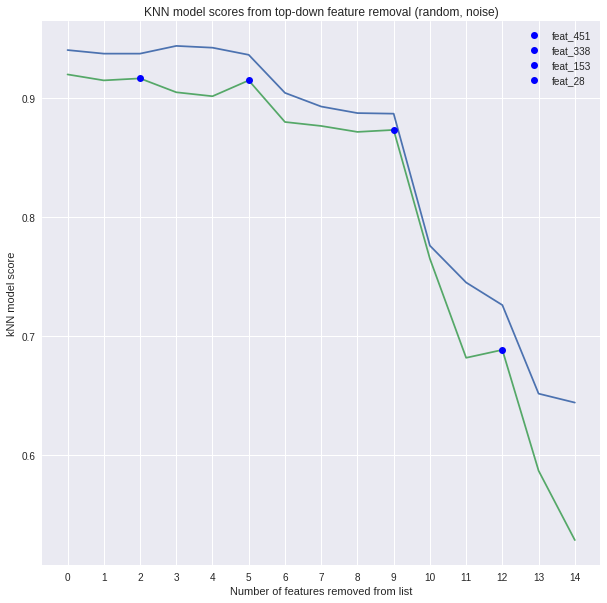

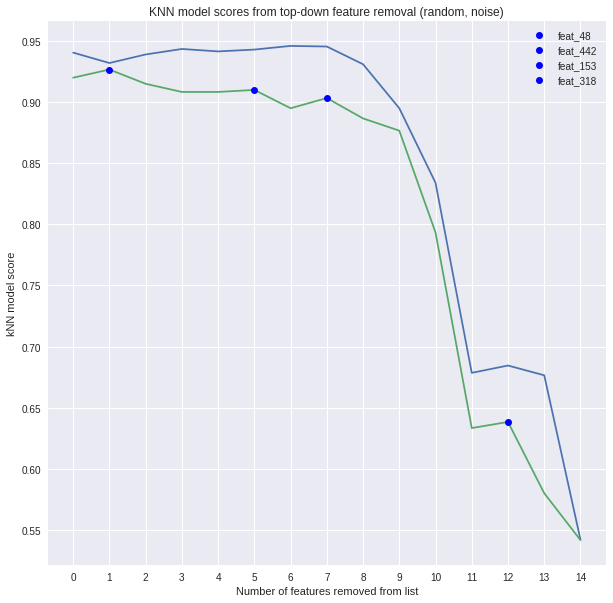

TOP RANDOMIZED NOISE FEATURES: [28, 48, 153, 318, 338, 442, 451]


,noise_removal_1
train_score,0.9435
val_score,0.8800


In [8]:
top_20_real_features = sorted([153,442,318,433,241,28,378,475,48,472,451,493,453,281,64,128,105,336,338,455])
best_score_list = [28, 48, 105, 128, 153, 281, 318, 336, 338, 378, 442, 451, 455, 472, 475]

removeable_feats = list_top_dipped_feats(best_score_list, random=True, noise=True)

with_noise_removed_feats = removerizer(best_score_list, removeable_feats)

noise_removal_1_df = train_val_scorer_df_maker_KNNC(with_noise_removed_feats, 'noise_removal_1')
noise_removal_1_df

In [9]:
second_best_score_list = [28, 48, 105, 128, 153, 281, 318, 336, 338, 378, 442, 451, 455, 472, 475]
best_score_list = [28,48,64,105,128,153,241,318,336,338,378,433,442,451,453,455,475,493]
noise_removal_df = train_val_scorer_df_maker_KNNC(best_score_list, 'noise_removal')

In [10]:
len(best_score_list)

18

In [11]:
noise_removal_df

,noise_removal
train_score,0.933000
val_score,0.923333


In [12]:
def brute_force_feature_combination_score_generator(list_of_feats, n_feats=1):
    
    list_of_combos = []
    
    for combo in combinations(list_of_feats, n_feats):
        list_of_combos.append(list(combo))

    print('Number of combinations:', len(list_of_combos))

    results = {}

    for features in list_of_combos:

        knc_params = {
        'n_neighbors':range(3,20,2)
        }

        y_train = train_uci_df['target']
        X_train = train_uci_df[features]
        y_val = val_uci_df['target']
        X_val = val_uci_df[features]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        knc_gs = GridSearchCV(KNeighborsClassifier(), param_grid=knc_params, cv=5, n_jobs=-1)
        knc_gs.fit(X_train_scaled, y_train)

        train_score = knc_gs.score(X_train_scaled, y_train)
        val_score = knc_gs.score(X_val_scaled, y_val)

        results['{}'.format(features)] = {'train_score':train_score, 'val_score':val_score}

    score_df = pd.DataFrame(results).T.sort_values('val_score', ascending=False)

    return score_df

In [13]:
best_scores_bf_10 = brute_force_feature_combination_score_generator(best_score_list, 3)
best_scores_bf_10[:10]

Number of combinations: 816


,train_score,val_score
"[241, 338, 378]",0.7815,0.765000
"[338, 378, 475]",0.7735,0.763333
"[28, 128, 453]",0.7555,0.763333
"[48, 338, 475]",0.7730,0.761667
"[128, 451, 453]",0.7760,0.760000
"[105, 318, 493]",0.7700,0.751667
"[105, 336, 442]",0.7645,0.751667
"[128, 442, 453]",0.7700,0.750000
"[128, 338, 475]",0.7615,0.750000
"[378, 442, 493]",0.7650,0.750000


In [14]:
# for x in score_df[:50].index:
#     print(x)

In [15]:
top_10_combo_scores = [[338, 378, 475], [48, 338, 475], [105, 336, 442],
       [336, 378, 472], [48, 472, 475], [128, 338, 475],
       [105, 338, 475], [128, 338, 451], [105, 442, 475],
       [128, 336, 338]]
top_14_combo_scores = [[338, 378, 475], [48, 338, 475], [336, 378, 472],
[105, 336, 442], [48, 472, 475], [128, 338, 475],
[105, 338, 475], [128, 338, 451], [105, 442, 475],
[378, 472, 475], [338, 378, 472], [128, 336, 338],
[105, 153, 475], [128, 442, 451]]
top_20_combo_scores = [[338, 378, 475], [48, 338, 475], [336, 378, 472],
[105, 336, 442], [48, 472, 475], [128, 338, 475],
[105, 338, 475], [128, 338, 451], [105, 442, 475],
[378, 472, 475], [338, 378, 472], [128, 336, 338],
[105, 153, 475], [128, 442, 451], [48, 338, 472],
[48, 336, 442], [153, 378, 442], [378, 442, 475],
[128, 336, 442], [318, 338, 475]]
top_50_combo_scores = [[338, 378, 475],[48, 338, 475],[336, 378, 472],[105, 336, 442],
 [48, 472, 475],[128, 338, 475],[105, 338, 475],[128, 338, 451],
 [105, 442, 475],[378, 472, 475],[338, 378, 472],[128, 336, 338],
 [105, 153, 475],[128, 442, 451],[48, 338, 472],[48, 336, 442],
 [153, 378, 442],[378, 442, 475],[128, 336, 442],[318, 338, 475],
 [48, 281, 338],[281, 378, 442],[48, 442, 475],[281, 378, 472],
 [338, 451, 475],[28, 338, 475],[48, 281, 442],[128, 442, 475],
 [105, 338, 451],[338, 378, 442],[48, 153, 475],[48, 336, 338],
 [128, 336, 472],[336, 378, 442],[153, 451, 475],[48, 153, 336],
 [48, 153, 338],[28, 153, 475],[153, 442, 475],[153, 336, 378],
 [105, 442, 451],[281, 318, 475],[105, 336, 338],[48, 153, 442],
 [281, 378, 451],[128, 336, 475],[28, 105, 338],[128, 153, 475],[48, 336, 472],[105, 336, 378]]

In [16]:
def make_set_from_list_of_lists(list_of_lists):
    uniques = []
    for x in list_of_lists:
        uniques = uniques + x

    return list(set(uniques))

In [17]:
top_10_combo_uniques = make_set_from_list_of_lists(top_10_combo_scores)
top_10_combo_uniques

[128, 451, 105, 48, 336, 338, 442, 472, 378, 475]

In [18]:
top_10_combo_scorers_df = train_val_scorer_df_maker_KNNC(top_10_combo_uniques, 'top_10_combo_scorers')
top_10_combo_scorers_df

,top_10_combo_scorers
train_score,0.921000
val_score,0.908333


In [19]:
top_14_combo_uniques = make_set_from_list_of_lists(top_14_combo_scores)
top_14_combo_uniques

[128, 451, 105, 48, 336, 338, 442, 472, 153, 378, 475]

In [20]:
top_14_combo_scorers_df = train_val_scorer_df_maker_KNNC(top_14_combo_uniques, 'top_14_combo_scorers')
top_14_combo_scorers_df

,top_14_combo_scorers
train_score,0.934000
val_score,0.911667


In [21]:
top_20_combo_uniques = make_set_from_list_of_lists(top_20_combo_scores)
top_20_combo_uniques

[128, 451, 105, 48, 336, 338, 442, 472, 153, 378, 475, 318]

In [22]:
top_20_combo_scorers_df = train_val_scorer_df_maker_KNNC(top_20_combo_uniques, 'top_20_combo_scorers')
top_20_combo_scorers_df

,top_20_combo_scorers
train_score,0.939500
val_score,0.913333


In [23]:
top_50_combo_uniques = make_set_from_list_of_lists(top_50_combo_scores)
print(top_50_combo_uniques)

top_50_combo_scorers_df = train_val_scorer_df_maker_KNNC(top_50_combo_uniques, 'top_50_combo_scorers')
top_50_combo_scorers_df

[128, 451, 281, 105, 48, 336, 338, 442, 472, 153, 378, 475, 28, 318]


,top_50_combo_scorers
train_score,0.94
val_score,0.91


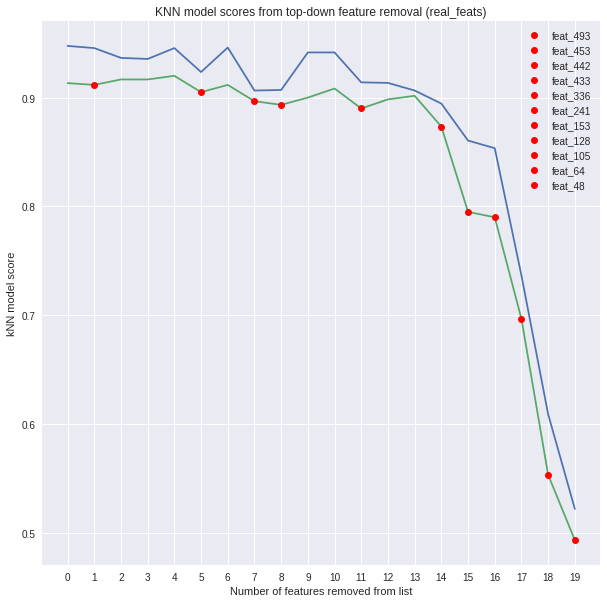

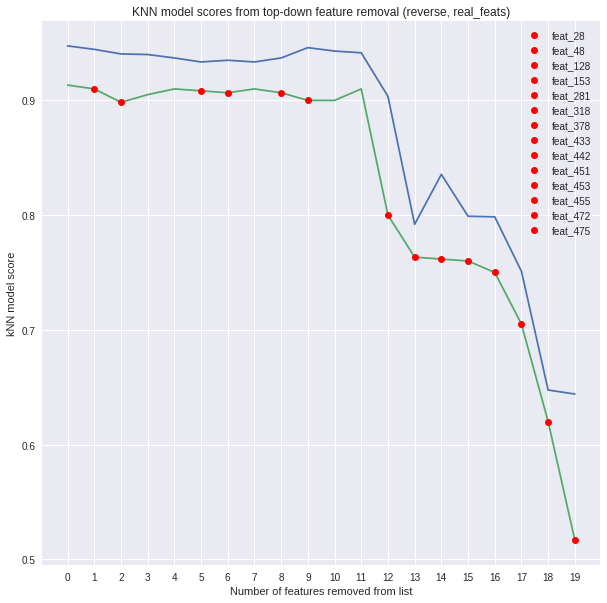

TOP REAL FEATURES: [28, 48, 128, 153, 281, 336, 433, 442, 453, 493]


[28, 48, 128, 153, 281, 336, 433, 442, 453, 493]

In [24]:
all_dipped_top_20_feats = list_top_dipped_feats(top_20_real_features)
all_dipped_top_20_feats

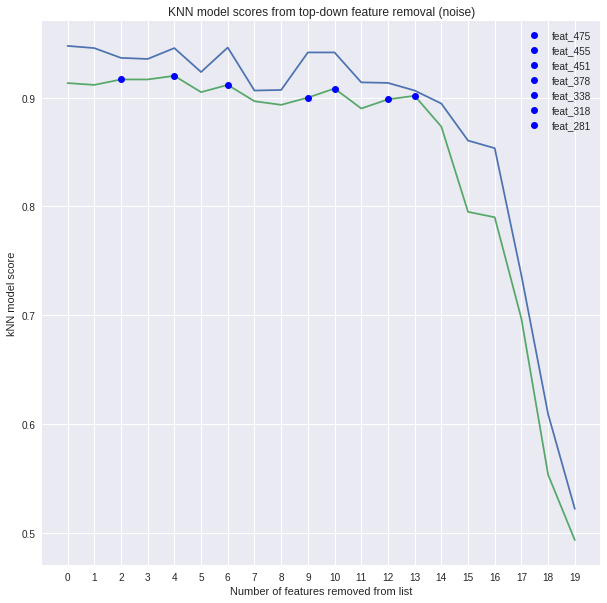

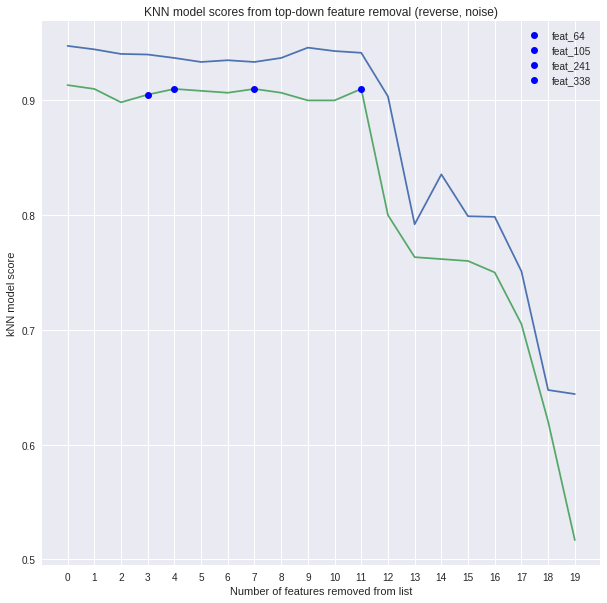

TOP NOISE FEATURES: [64, 105, 241, 338, 378, 451, 455, 475]


[64, 105, 241, 338, 378, 451, 455, 475]

In [25]:
noise_all_dipped_top_20_feats = list_top_dipped_feats(top_20_real_features, noise=True)
noise_all_dipped_top_20_feats

In [26]:
train_val_all_dipped_scores_df = train_val_scorer_df_maker_KNNC(all_dipped_top_20_feats, 'all_dipped_feats')
train_val_all_dipped_scores_df

,all_dipped_feats
train_score,0.943500
val_score,0.896667


In [27]:
merged_score_df = pd.merge(train_val_scores_df, train_val_all_dipped_scores_df, left_index=True, right_index=True)
merged_score_df.T.sort_values('val_score', ascending=False)

,train_score,val_score
top_20_real_features,0.9475,0.913333
all_dipped_feats,0.9435,0.896667
top_12_real_features,0.9410,0.893333
top_7_real_features,0.8760,0.830000
top_5_real_features,0.8380,0.808333


### Results of manual top-down feature elimination

The first time 

In [28]:
rotater_df = rotator_score_df_generator(top_20_real_features)

In [29]:
rotater_df

,train_score,val_score
28,0.9445,0.910000
48,0.9410,0.901667
64,0.9465,0.915000
105,0.9360,0.911667
128,0.9460,0.910000
153,0.9375,0.915000
241,0.9475,0.908333
281,0.9365,0.921667
318,0.9430,0.906667
336,0.9460,0.913333


In [30]:
score_to_beat = noise_removal_df.iloc[1]['noise_removal']
score_to_beat

0.92333333333333334

In [31]:
good_feats = []

for i,x in enumerate(rotater_df['val_score']):
    index_list = list(rotater_df.index)
    if x <= score_to_beat:
        good_feats.append(index_list[i])
        
good_feats

[28,
 48,
 64,
 105,
 128,
 153,
 241,
 281,
 318,
 336,
 338,
 378,
 433,
 442,
 451,
 453,
 455,
 472,
 475,
 493]

In [32]:
good_feats_scores_df = train_val_scorer_df_maker_KNNC(good_feats, 'good_feats')

In [33]:
good_feats_scores_df

,good_feats
train_score,0.947500
val_score,0.913333


In [34]:
top_14_elasticnet_real_features_scores_df = train_val_scorer_df_maker_KNNC(top_14_elasticnet_real_features, 'top_14_elasticnet_real_features')
top_14_elasticnet_real_features_scores_df

,top_14_elasticnet_real_features
train_score,0.929000
val_score,0.898333


In [37]:
# Using GridSearchCV to fit my model with all the training data and using the validation data
results = {}
all_feat_list_names = ['best_score_list', 'all_dipped_top_20_feats','top_20_real_features', 'top_12_real_features', 'top_7_real_features', \
                       'top_5_real_features', 'top_14_elasticnet_real_features', 'good_feats']

all_feat_lists = [best_score_list, all_dipped_top_20_feats, top_20_real_features, top_12_real_features, top_7_real_features, \
                  top_5_real_features, top_14_elasticnet_real_features, good_feats]


for i, feat_list in enumerate(all_feat_lists):

    knc_params = {
    'n_neighbors':range(1,50,2)
    }

    y_train = train_uci_df['target']
    X_train = train_uci_df[feat_list]
    y_val = val_uci_df['target']
    X_val = val_uci_df[feat_list]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    knc_gs = GridSearchCV(KNeighborsClassifier(), param_grid=knc_params, cv=5, n_jobs=-1)
    knc_gs.fit(X_train_scaled, y_train)
    
    train_score = knc_gs.score(X_train_scaled, y_train)
    val_score = knc_gs.score(X_val_scaled, y_val)
    
    results[all_feat_list_names[i]] = {'train_score':train_score, 'val_score':val_score, }

In [38]:
all_scores_df = pd.DataFrame(results).T.sort_values('val_score', ascending=False)
all_scores_df

,train_score,val_score
best_score_list,0.9330,0.923333
good_feats,0.9475,0.913333
top_20_real_features,0.9475,0.913333
top_14_elasticnet_real_features,0.9290,0.898333
all_dipped_top_20_feats,0.9435,0.896667
top_12_real_features,0.9410,0.893333
top_7_real_features,0.8760,0.830000
top_5_real_features,0.8380,0.808333
